# Solving for T(R) and c(R): balancing solid growth and diffusion from the F-layer

Our particle growth calculations can yield solid growth rates
along the trajectory and we can relate this to the production of
heat and oxygen from crystal growth as a function of height above
the ICB. Here we seek to treat these as source terms in a
balance between the heat production (and oxygen content)
with diffusion out of the F-layer.
The idea is that we can then proceed in an iterative manner: (1) 
Set a temperature and composition profile. (2) Calculate the
heat and oxygen production rate (by considering the particle 
falling and growing problem for all nucleation radii).
(3) Find a temperature and
composition profile that is consistent with this production rate
and allows the heat and oxygen production to be balanced by diffusion
out of the layer. (4) Feed the profiles from (3) back into
(2) and repeat until convergence. Both heat and oxygen production in
the layer will lead to an increase in the temperature and oxygen content
of the layer. Both changes will tend to reduce driving force for nucleation
and growth so we will have fewer particles and slower nucleation, hence 
slowing the approach to equilibrium. However,
the equilibrium solid content will also reduce (potentially all the way to
zero if the whole layer ends up on the liquidus) so the F-layer will be
closer to equilibrium for the same solid content. With luck we'll converge
to a solution in a few iterations.

This notebook outlines the development of the solver for step (3)
in a way that is decoupled from the rest of the code. Note that the
same solver can be used for the two systems (just exchanging chemical 
and thermal diffusivity and choosing different boundary conditions and
source terms) and these can be treated separately unless we want to 
couple e.g. thermal conduction and oxygen content of the melt. We
neglect Soret effects, assume that the liquid is stably 
stratified (so no heat or chemical transfer via convection),
and that the falling particles are always in thermal equilibrium
(the temperature of the particles is the same as the temperature
of the stratified liquid). 

In [1]:
# Imports and system setup
import numpy as np
import scipy.integrate as spi
import scipy.interpolate as spinterp

import matplotlib.pyplot as plt
%matplotlib inline

r_icb = 1221.5e3
f_layer_thickness = 200.0e3



## Heat production balances thermal diffusion

Our falling particles liberate heat as they fall and grow. By assumption this heat production is balanced by diffusion of heat out
of the F-layer and the temperature of the layer does not change with time. For our spherical geometry we need to find the
temperature profile which satisfies:

$$\frac{\mathrm{d} T(R)}{\mathrm{d} t} \rho c_p =  
    \rho H(R) + \frac{1}{R^2}\frac{\mathrm{d}}{\mathrm{d} R}\left(k R^2 \frac{\mathrm{d} T(R)}{\mathrm{d} R} \right)
        = 0 $$

where $k$ is the thermal conductivity, $c_p$ is the *specific* heat capacity, $\rho$ is the density and $H(R)$ a specified (and
temperature independent) function defining the heat production rate (in W/kg). The heat capacity, density and conductivity 
ought to relate to the slurry as a whole and be a weighted average of the solid and liquid, but as the solid fraction is low
we will neglect the effect of the solid on these terms. We further assume that the conductivity is independent of pressure
and temperature. We seek $T(R)$ that solves this equation for specified boundary conditions (see below).

**The equation above is probably the only one we need in the manuscript, with a brief note on how it is solved and the BCs.
I'll remove *this* note once I've written that text**

### Boundary conditions

I imagine that the temperature at the top of the layer is defined by the rapidly convecting bulk of the 
outer core. Heat can be rapidly removed from this boundary. We can sensibly impose a fixed temperature
boundary condition at the top of the layer (set to the intersection of the liquidus and the adiabat
at the top of the F-layer). Whatever we do about the lower boundary condition, this also means we can
evaluate the heat flux out of the layer from the temperature gradient on this boundary, allowing the
possibility of coupling our F-layer model to a longer-timescale thermal evolution model of the cooling
of the core.

I suppose one day there may be call for a fixed gradient boundary condition on the upper interface.
One example would be a snow zone just below the core-mantle boundary where conduction in the mantle
sets the heat flux out of the core (e.g. on a small planet).

The correct boundary condition at the bottom of the F-layer is a little less obvious. I think it
depends on how we think the inner core grows, what we impose about the behavior of the inner core,
and potentially what is numerically convenient.

One way forward would be saying, for the sake of argument, that the inner core only grows by
sedimentation, that the growth rate is an output of the F-layer model, and that the inner core
is isothermal. In this case, the heat flux out of the inner core will be zero, and the boundary 
condition will be zero thermal gradient on the lower boundary.

An alternative setup would be to set the growth rate of the inner core, subtract the growth
rate due to sedimentation, and calculate the heat released at the lower boundary by direct
growth. This would result in a lower boundary condition with a non-zero thermal gradient.
This seems like a sensible setup, but one issue may be that some of our solutions give
enormous growth rates due to sedimentation and this would need to be balanced by melting
at the ICB to such that the growth rate matches the imposed rate. Even if this makes
physical sense, I suspect it won't lead to an overall problem that converges.

The third possibility is to set the temperature at the lower boundary. This would
imply some background thermal conduction across the F-layer (zero if we chose the
adiabatic temperature) and could allow heat to be conducted from the F-layer 
into the inner core. This may be sensible, may yield solutions that are easier
to check, and would be the natural setup for a shallow snow zone. 

What I've done is implement a solver that allows either fixed temperature gradient
or fixed temperature on the top and bottom boundary. The setup phase of the problem
just checks that one condition is set at each boundary.

### Numerical solution

We're finding $T(R)$ given a second order ordinary differential equation and
two boundary conditions. This can be done numerically using a collocation scheme
implemented as `scipy.integrate.solve_bvp`. What we need to do is write the 
second order ODE as a system of two coupled first order equations, define these
and the boundary condition residuals as functions (binding $H(R)$ to the 
first function) and pass these into the solver with an initial guess at the
solution (as values on an initial set of mesh points). We get back a new
set of mesh points, a continuous spline representing the solution ($T(R)$
and $dT(R)/dT$) as well as these solutions on a refined set of mesh points.

To write the second order ODE as a system of two first order equations we 
first expanded and simplify:

$$\rho H(R) + \frac{1}{R^2} \left[ k R^2 \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} 
    + 2 k R \frac{\mathrm{d} T}{\mathrm{d} R}\right] = 0,$$

$$\rho H(R) + k \frac{\mathrm{d}^2 T}{\mathrm{d} R^2} 
    + \frac{2 k}{ R} \frac{\mathrm{d} T}{\mathrm{d} R} = 0.$$
    
    
Then make the substitutions $y_0 = T$ and $y_1 = \frac{\mathrm{d} T}{\mathrm{d} R}$ so that
 $y_1^{\prime} = \frac{\mathrm{d}^2 T}{\mathrm{d} R^2}$. Then:

$$\rho H(R) + k y_1^{\prime} + \frac{2 k}{ R} y_1 = 0$$

We can then express the system of equations as:

$$y_0^{\prime} = y_1$$

$$y_1^{\prime} = \frac{- \rho H(R) - (2 k / R) y_1}{k}$$

I'm using $y_0$ and $y_1$, rather than 1 and 2, to match python's index 
notation, will accept $\rho Q(R)$ (which is the volumetric heat production
rate in W m$^{-3}$) as an array of values along with arrays representing 
$R$ and the initial guesses for $T$ and $\frac{\mathrm{d} T}{\mathrm{d} R}$.
All four arrays need to be the same length and two (out of four) boundary
conditions must be supplied.

In [2]:
def solve_diffusion(rs, init_guess, sources, diffusivity, topbc):

    # Linear interpolator for sources
    source_fun = spinterp.interp1d(rs, sources, fill_value=0.0)
    
    def fun(x, y):
        sources = 0.0
        dy0_by_dx = y[1]
        dy1_by_dx = (- source_fun(x) - (2.0 * 
                     diffusivity / x) * y[1]
                    ) / (diffusivity)
        
        return np.vstack((dy0_by_dx, dy1_by_dx))
                     
    def bc(ya, yb):
        return np.array([ya[1], yb[0] - topbc])
    
    result = spi.solve_bvp(fun, bc, rs, init_guess)
    
    return result

def plot_diffusion_solution(rs, init_guess, sources, diffusivity, topbc, res):
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4))
    r_plot = np.linspace(rs[0], rs[-1], num=500)
    t_plot = res.sol(r_plot)[0]
    dt_dr_plot = res.sol(r_plot)[1]
    
    axs[0].plot(r_plot/1000.0, t_plot)
    axs[1].plot(r_plot/1000.0, dt_dr_plot)
    
    axs[0].plot(rs/1000.0, init_guess[0], '--') 
    axs[1].plot(rs/1000.0, init_guess[1], '--')
    
    axs[1].plot(rs[0]/1000.0, 0.0, 'o')
    axs[0].plot(rs[-1]/1000.0, topbc, 'o')
    
    axs[2].plot(rs/1000, sources)
    
    axs[0].set_xlabel('$R$ (km)')
    axs[0].set_ylabel('$T(R)$ (K)')
    axs[1].set_xlabel('$R$ (km)')
    axs[1].set_ylabel('$\mathrm{d}T / \mathrm{d}R$ (K)')
    axs[2].set_xlabel('$R$ (km)')
    axs[2].set_ylabel('$Q(R)$ (??)')
    
    dt_dr_check = np.gradient(t_plot, r_plot)
    axs[1].plot(r_plot/1000.0, dt_dr_check, ':')
    
    fig.tight_layout()
    plt.show()

## Test case 1

This is something like we may expect. Heat sources distributed evenly 
in the layer (but zero on the boundaries). Try with a uniform initial guess
at the temperature (matching the boundary condition at the top) and thus zero derivative (matching the boundary condition at the bottom). Gradient needs to let
all the heat conduct out of the top so it gets colder downwards.

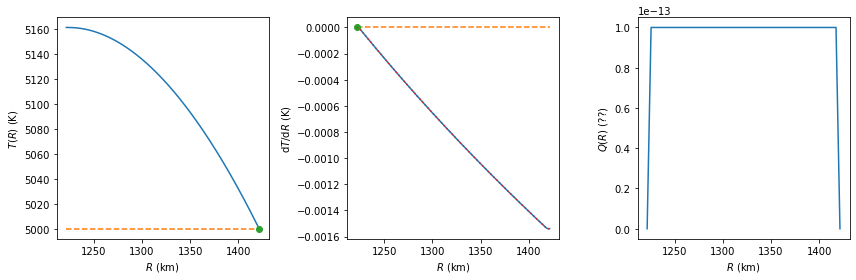

In [3]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.ones_like(r) * 1.0E-13 # J m^-3 s^-1?
heat_sources[0] = 0.0
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)

## Test case 2

Something approximating no slurry, put all heat sources on the lower boundary. 
Keep the  uniform initial guess at the temperature (matching the boundary condition at the top) and thus zero derivative (matching the boundary condition at the bottom). I'll keep the total heat production rate fixed.

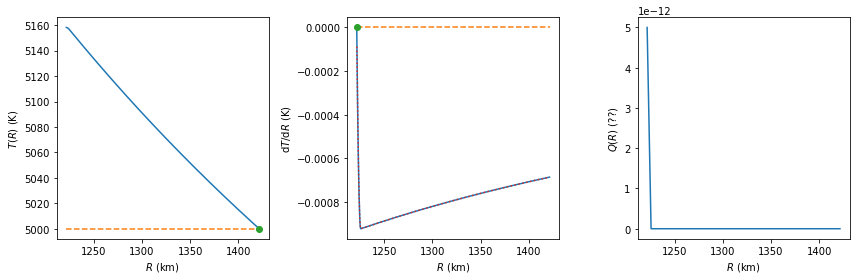

In [4]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.zeros_like(r) 
heat_sources[0] = r.size * 1.0E-13 # J m^-3 s^-1?
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)

## Test case 3

What if we put all the heat sources in the middle of the layer?

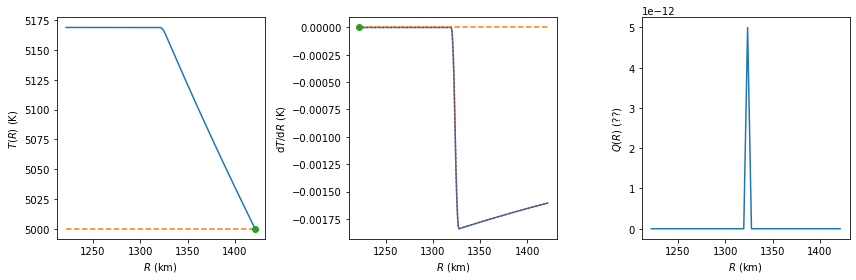

In [5]:
r = np.linspace(r_icb, r_icb+f_layer_thickness, num=50)

k     = 100.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)


heat_sources = np.zeros_like(r) 
heat_sources[25] = r.size * 1.0E-13 # J m^-3 s^-1?
heat_sources[-1] = 0.0


t_top = 5000.0
initial_t = np.ones_like(r) * t_top
initial_dtdr = np.zeros_like(r)

res = solve_diffusion(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top)

plot_diffusion_solution(r, np.vstack((initial_t, initial_dtdr)), 
                                   heat_sources, kappa, t_top, res)